<a href="https://colab.research.google.com/github/austin-strom/text2face/blob/main/Automatic_Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [2]:
!gdown --id 1nD6kNAgIVjxpzIScJNLqUyRA1qEkc4Op
!gdown --id 1cwcYbl0dhXEzmdbee_K_H6jcndbsxT2o         

!unzip -u -q face2text_v0.1.zip -d face2text_v0.1
!unzip -u -q face2text_v1.0.zip -d face2text_v1.0

Downloading...
From: https://drive.google.com/uc?id=1nD6kNAgIVjxpzIScJNLqUyRA1qEkc4Op
To: /content/face2text_v0.1.zip
100% 156k/156k [00:00<00:00, 56.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cwcYbl0dhXEzmdbee_K_H6jcndbsxT2o
To: /content/face2text_v1.0.zip
100% 217k/217k [00:00<00:00, 68.2MB/s]


In [3]:
# # This is moving the v0.1 file to the proper data dir for testing

!mkdir face2text_v0.1/data
# !mv face2text_v0.1/ Face2Text/.

!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
!tar -xvf lfw.tgz
!mv lfw face2text_v0.1/data/.

Streaming output truncated to the last 5000 lines.
lfw/Luis_Sanchez/
lfw/Luis_Sanchez/Luis_Sanchez_0001.jpg
lfw/Juliette_Binoche/
lfw/Juliette_Binoche/Juliette_Binoche_0001.jpg
lfw/Joel_Todd/
lfw/Joel_Todd/Joel_Todd_0001.jpg
lfw/Allan_Wagner/
lfw/Allan_Wagner/Allan_Wagner_0001.jpg
lfw/Alejandro_Fernandez/
lfw/Alejandro_Fernandez/Alejandro_Fernandez_0001.jpg
lfw/Guillaume_Depardieu/
lfw/Guillaume_Depardieu/Guillaume_Depardieu_0001.jpg
lfw/Delphine_Chuillot/
lfw/Delphine_Chuillot/Delphine_Chuillot_0001.jpg
lfw/Paul_LeClerc/
lfw/Paul_LeClerc/Paul_LeClerc_0001.jpg
lfw/Eddie_Jordan/
lfw/Eddie_Jordan/Eddie_Jordan_0001.jpg
lfw/Lionel_Richie/
lfw/Lionel_Richie/Lionel_Richie_0001.jpg
lfw/Lionel_Richie/Lionel_Richie_0002.jpg
lfw/Jose_Viegas_Filho/
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw/Roger_Mahony/
lfw/Roger_Mahony/Roger_Mahony_0001.jpg
lfw/Clay_Aiken/
lfw/Clay_Aiken/Clay_Aiken_0001.jpg
lfw/Clay_Aiken/Clay_Aiken_0002.jpg
lfw/Clay_Ai

In [4]:
!cd face2text_v0.1/data/lfw/ && ls

Aaron_Eckhart			 Joshua_Harapko
Aaron_Guiel			 Joshua_Perper
Aaron_Patterson			 Joxel_Garcia
Aaron_Peirsol			 Joy_Bryant
Aaron_Pena			 Joy_Lee_Sadler
Aaron_Sorkin			 JP_Suarez
Aaron_Tippin			 JT_Snow
Abba_Eban			 Juan_Antonio_Samaranch
Abbas_Kiarostami		 Juan_Carlos
Abdel_Aziz_Al-Hakim		 Juan_Carlos_Ferrero
Abdel_Madi_Shabneh		 Juan_Carlos_Morales
Abdel_Nasser_Assidi		 Juan_Carlos_Ortega
Abdoulaye_Wade			 Juanes
Abdulaziz_Kamilov		 Juan_Fernandez
Abdullah			 Juan_Francisco_Palencia
Abdullah_Ahmad_Badawi		 Juan_Ignacio_Chela
Abdullah_al-Attiyah		 Juan_Jose_Lucas
Abdullah_Gul			 Juan_Manuel_Marquez
Abdullah_Nasseef		 Juan_Pablo_Montoya
Abdullatif_Sener		 Juan_Roman_Carrasco
Abdul_Majeed_Shobokshi		 Juan_Roman_Riquelme
Abdul_Rahman			 Juan_Sanchez
Abel_Aguilar			 Juan_Valencia_Osorio
Abel_Pacheco			 Judd_Davies
Abid_Hamid_Mahmud_Al-Tikriti	 Jude_Law
Abner_Martinez			 Judi_Dench
Abraham_Foxman			 Judi_Patton
Aby_Har-Even			 Judith_Nathan
Adam_Ant			 Judy_Dean
Adam_Freier			 Judy_Genshaft
A

In [166]:
!ls face2text_v0.1/data/lfw/Dagmar_Dunlevy

Dagmar_Dunlevy_0001.jpg


In [5]:
!cd face2text_v0.1/ && cat clean.json

Streaming output truncated to the last 5000 lines.
        "descriptions": [
            {
                "desc_id": 230,
                "text": "Focused to get his point, say what must be said, he is not agreeing with what is being said so hand gestures to emphasise his point"
            },
            {
                "desc_id": 524,
                "text": "Very receded hair, dark brown and straight hair. Probably due to stress and age, he seems like he is a politician of some kind. Metallic round glasses, clean shaven face, well dressed attire."
            },
            {
                "desc_id": 1259,
                "text": "50-60 something bald man. Glasses, dark hair and eyes. Apparently in the middle of a serious discussion explaining something."
            }
        ]
    },
    {
        "img_id": 129,
        "image": "Kathy_Baker/Kathy_Baker_0001.bmp",
        "descriptions": [
            {
                "desc_id": 363,
                "text": "She looks very h

In [6]:
import json
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text


filename = "face2text_v0.1/clean.json"
# load descriptions
doc = load_doc(filename)
with open(filename) as f:
    jj = json.load(f)
# jj = json.dumps(doc[1:-1])
print(len(jj))


400


In [7]:
def load_descriptions(doc):
  mapping = dict()
  # process lines
  for line in jj:
    print(line)
    # take the first token as the image id, the rest as the description
    image_id = line["img_id"]
    image_path = line["image"]
    # convert description tokens back to string
    image_desc = line["descriptions"]
    # create the list if needed
    mapping[image_path] = list()
    # store description
    for desc in image_desc:
      print(desc)
      mapping[image_path].append(desc["text"])
  return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

{'img_id': 1, 'image': 'Katerina_Smrzova/Katerina_Smrzova_0001.bmp', 'descriptions': [{'desc_id': 582, 'text': 'A young woman with long light brown hair cut in layers and parted in the middle, a small nose and a nice open smile.'}, {'desc_id': 1326, 'text': 'A young girl posing for the camera'}]}
{'desc_id': 582, 'text': 'A young woman with long light brown hair cut in layers and parted in the middle, a small nose and a nice open smile.'}
{'desc_id': 1326, 'text': 'A young girl posing for the camera'}
{'img_id': 2, 'image': 'John_Rowland/John_Rowland_0001.bmp', 'descriptions': [{'desc_id': 178, 'text': 'Middleaged man - very traditional square jawed american features looking pensive or waiting for a result of somesort. looks like a politician'}, {'desc_id': 851, 'text': 'brown/greyish hair, brown eyes'}]}
{'desc_id': 178, 'text': 'Middleaged man - very traditional square jawed american features looking pensive or waiting for a result of somesort. looks like a politician'}
{'desc_id': 8

In [8]:
list(descriptions.keys())[:5]

['Katerina_Smrzova/Katerina_Smrzova_0001.bmp',
 'John_Rowland/John_Rowland_0001.bmp',
 'Laurent_Gbagbo/Laurent_Gbagbo_0001.bmp',
 'Kiki_Vandeweghe/Kiki_Vandeweghe_0001.bmp',
 'Arianna_Huffington/Arianna_Huffington_0001.bmp']

In [9]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [10]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 2893


In [11]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
  lines = list()
  for key, desc_list in descriptions.items():
    for desc in desc_list:
      lines.append(str(key) + ' ' + desc)
  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)
  file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [12]:
!sed -i 's/bmp/jpg/g' descriptions.txt

In [13]:
# load a pre-defined list of photo identifiers
def load_set(filename):
  name_mapping = []
  # process lines
  for line in jj:
    # take the first token as the image id, the rest as the description
    # name_mapping.append( line["img_id"])
    name_mapping.append( line["image"])
  return name_mapping

# load training dataset (6K)
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 400


In [191]:
# Below path contains all the images
images = 'face2text_v0.1/data/lfw/'
# Create a list of all image names in the directory
img = glob.glob(images + '**/*.jpg')
print(len(img))
# !ls face2text_v0.1/data/lfw


13233


In [15]:
# # Below file conatains the names of images to be used in train data
# train_images_file = "face2text_v0.1/clean.json"
# # Read the train image names in a set
# train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# # Create a list of all the training images with their full path names
# train_img = []

# for i in img: # img is list of full path names of all images
#     if i[len(images):] in train_images: # Check if the image belongs to training set
#         train_img.append(i) # Add it to the list of train images

### Use ImageMagik??

In [17]:
def load_set_name(filename):
  name_mapping = []
  # process lines
  for line in jj:
    # take the first token as the image id, the rest as the description
    name_mapping.append( line["image"].replace('bmp', 'jpg'))

  return name_mapping
# print(len(image_names))
print(len(descriptions))
image_names = load_set_name(filename)
train_img = image_names[:300]
test_img = image_names[300:]

400


In [18]:
print(image_names)

['Katerina_Smrzova/Katerina_Smrzova_0001.jpg', 'John_Rowland/John_Rowland_0001.jpg', 'Laurent_Gbagbo/Laurent_Gbagbo_0001.jpg', 'Kiki_Vandeweghe/Kiki_Vandeweghe_0001.jpg', 'Arianna_Huffington/Arianna_Huffington_0001.jpg', 'Barzan_al-Tikriti/Barzan_al-Tikriti_0001.jpg', 'Laurie_Pirtle/Laurie_Pirtle_0001.jpg', 'Kirk_Douglas/Kirk_Douglas_0001.jpg', 'Hutomo_Mandala_Putra/Hutomo_Mandala_Putra_0001.jpg', 'Humberto_Espinoza/Humberto_Espinoza_0001.jpg', 'Anita_DeFrantz/Anita_DeFrantz_0001.jpg', 'Antonio_Elias_Saca/Antonio_Elias_Saca_0001.jpg', 'Cheryl_Tiegs/Cheryl_Tiegs_0001.jpg', 'Christian_Gimenez/Christian_Gimenez_0001.jpg', 'Gennifer_Flowers/Gennifer_Flowers_0001.jpg', 'Gerhard_Boekel/Gerhard_Boekel_0001.jpg', 'Lindsay_Davenport/Lindsay_Davenport_0001.jpg', 'Leon_Barmore/Leon_Barmore_0001.jpg', 'Lisa_Marie_Presley/Lisa_Marie_Presley_0001.jpg', 'Leuris_Pupo/Leuris_Pupo_0001.jpg', 'Barbra_Streisand/Barbra_Streisand_0001.jpg', 'Bill_Paxton/Bill_Paxton_0001.jpg', 'Lisa_Stansfield/Lisa_Stansfiel

In [19]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
  # load document
  doc = load_doc(filename)
  descriptions = dict()
  for line in doc.split('\n'):
    # print(line)
    # split line by white space
    tokens = line.split()
    # split id from description
    image_id, image_desc = tokens[0], tokens[1:]
    # skip images not in the set
    print(tokens)
    if image_id in dataset:
      # create list
      if image_id not in descriptions:
        descriptions[image_id] = list()
      # wrap description in tokens
      desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
      # store
      descriptions[image_id].append(desc)
  return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', image_names)
print('Descriptions: train=%d' % len(train_descriptions))

['Katerina_Smrzova/Katerina_Smrzova_0001.jpg', 'young', 'woman', 'with', 'long', 'light', 'brown', 'hair', 'cut', 'in', 'layers', 'and', 'parted', 'in', 'the', 'middle', 'small', 'nose', 'and', 'nice', 'open', 'smile']
['Katerina_Smrzova/Katerina_Smrzova_0001.jpg', 'young', 'girl', 'posing', 'for', 'the', 'camera']
['John_Rowland/John_Rowland_0001.jpg', 'middleaged', 'man', 'very', 'traditional', 'square', 'jawed', 'american', 'features', 'looking', 'pensive', 'or', 'waiting', 'for', 'result', 'of', 'somesort', 'looks', 'like', 'politician']
['John_Rowland/John_Rowland_0001.jpg', 'browngreyish', 'hair', 'brown', 'eyes']
['Laurent_Gbagbo/Laurent_Gbagbo_0001.jpg', 'serious', 'man', 'most', 'probably', 'politically', 'involved', 'whiting', 'hair', 'with', 'intense', 'eyes', 'smart', 'and', 'looks', 'important']
['Laurent_Gbagbo/Laurent_Gbagbo_0001.jpg', 'coloured', 'man', 'in', 'his', 'late', 'dressed', 'in', 'suit', 'and', 'tie', 'salt', 'and', 'pepper', 'hair', 'and', 'round', 'pleasant

In [20]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [21]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 1s 0us/step


In [22]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [23]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [24]:
print(train_img)

['Katerina_Smrzova/Katerina_Smrzova_0001.jpg', 'John_Rowland/John_Rowland_0001.jpg', 'Laurent_Gbagbo/Laurent_Gbagbo_0001.jpg', 'Kiki_Vandeweghe/Kiki_Vandeweghe_0001.jpg', 'Arianna_Huffington/Arianna_Huffington_0001.jpg', 'Barzan_al-Tikriti/Barzan_al-Tikriti_0001.jpg', 'Laurie_Pirtle/Laurie_Pirtle_0001.jpg', 'Kirk_Douglas/Kirk_Douglas_0001.jpg', 'Hutomo_Mandala_Putra/Hutomo_Mandala_Putra_0001.jpg', 'Humberto_Espinoza/Humberto_Espinoza_0001.jpg', 'Anita_DeFrantz/Anita_DeFrantz_0001.jpg', 'Antonio_Elias_Saca/Antonio_Elias_Saca_0001.jpg', 'Cheryl_Tiegs/Cheryl_Tiegs_0001.jpg', 'Christian_Gimenez/Christian_Gimenez_0001.jpg', 'Gennifer_Flowers/Gennifer_Flowers_0001.jpg', 'Gerhard_Boekel/Gerhard_Boekel_0001.jpg', 'Lindsay_Davenport/Lindsay_Davenport_0001.jpg', 'Leon_Barmore/Leon_Barmore_0001.jpg', 'Lisa_Marie_Presley/Lisa_Marie_Presley_0001.jpg', 'Leuris_Pupo/Leuris_Pupo_0001.jpg', 'Barbra_Streisand/Barbra_Streisand_0001.jpg', 'Bill_Paxton/Bill_Paxton_0001.jpg', 'Lisa_Stansfield/Lisa_Stansfiel

In [25]:
print(images)

face2text_v0.1/data/lfw/


In [26]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}

for img in train_img:
  encoding_train[img] = encode(images + img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 31.364698886871338


In [27]:
# Save the bottleneck train features to disk
import pickle
with open(filename + "encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [28]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:

    # encoding_test[img[len(images):]] = encode(images+img)
    encoding_test[img] = encode(images+img)

print("Time taken in seconds =", time()-start)

Time taken in seconds = 4.912567377090454


In [29]:
# Save the bottleneck test features to disk
with open( filename + "encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [30]:
train_features = load(open(filename + "encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=300


In [171]:
print(encoding_test['Dagmar_Dunlevy/Dagmar_Dunlevy_0001.jpg'])
print(len(train_descriptions))

[1.2735947  0.45393646 0.49410996 ... 0.4857791  0.24257551 0.19772205]
400


In [31]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

1237

In [32]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 2896 -> 336


In [33]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [34]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

337

In [35]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 94


In [37]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip


--2021-04-25 20:51:46--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-04-25 20:51:46--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-04-25 20:51:46--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [38]:
!ls

# Load Glove vectors
embeddings_index = {} # empty dictionary
f = open(os.path.join('glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

descriptions.txt    face2text_v1.0	glove.6B.200d.txt  glove.6B.zip
face2text_v0.1	    face2text_v1.0.zip	glove.6B.300d.txt  lfw.tgz
face2text_v0.1.zip  glove.6B.100d.txt	glove.6B.50d.txt   sample_data
Found 400000 word vectors.


In [39]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [40]:
embedding_matrix.shape
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.44117001 -0.38503    -0.65741998 ...  0.079701   -0.19667999
   0.36745   ]
 ...
 [ 0.62230003 -0.1426     -0.16478001 ...  0.16229001 -0.33930999
  -0.060914  ]
 [ 0.51972002 -0.82323998 -0.091937   ... -0.065029   -0.41604
   0.31454   ]
 [ 0.22572     0.24877    -0.16811    ...  0.64784002 -0.12033
   0.12215   ]]


In [157]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            # TODO: Key is currently the ID, which is just the number. Might change to the list index
    
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            # yield the batch data
            if n==num_photos_per_batch:
                # yield [[array(X1), array(X2)], array(y)]
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [158]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [159]:
# model.summary()

In [160]:
model.layers[2]

In [161]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [162]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [163]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [167]:
# generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
# print(next(generator))
# train_features['Dagmar_Dunlevy/Dagmar_Dunlevy_0001.jpg']

KeyError: ignored

In [ ]:


train_subset = {key: value for key, value in train_descriptions.items() if key in train_keys}
print(len(train_subset))
test_subset = {key: value for key, value in train_descriptions.items() if key in test_keys}
print(len(test_subset))
for i in range(epochs):
    generator = data_generator(train_subset, train_features, wordtoix, max_length, number_pics_per_bath)
    # model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

    model.save('./model_weights/model_' + str(i) + '.h5')

300
100
 51/133 [==========>...................] - ETA: 15s - loss: 1.8586

In [ ]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [188]:
model.save_weights('./model_weights/model_30.h5')

In [189]:
model.load_weights('./model_weights/model_30.h5')

In [190]:
# images = '../../storage/image_caption/dataset/Flicker8k_Dataset/'

In [192]:
# with open("../../storage/image_caption/dataset/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
#     encoding_test = load(encoded_pickle)

FileNotFoundError: ignored

In [195]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final
z=0

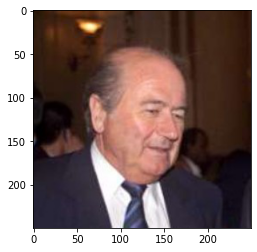

Greedy: serious looking


In [200]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))